In [1]:
import pandas as pd
import nltk
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import itertools

In [75]:
df = pd.read_csv("../data/lines.csv")
df.head()

,character,line,season,episode
0,Michael,All right Jim. Your quarterlies look very good...,1,1
1,Jim,"Oh, I told you. I couldn't close it. So...",1,1
2,Michael,So you've come to the master for guidance? Is ...,1,1
3,Jim,"Actually, you called me in here, but yeah.",1,1
4,Michael,"All right. Well, let me show you how it's done.",1,1


### EDA

Let's get some stats about the lines.

The total lines spoken by each character are easy to find. We can pick out the top ten,

In [76]:
# lines spoken by season by each character
line_counts = df.groupby(['season','character']).count()[['line']].reset_index()

# total lines spoken over the course of the series
total_lines = line_counts.groupby('character').sum().sort_values('line', ascending=False).reset_index()
top_ten = list(total_lines[0:10].character)  # ten characters that spoke the most lines

Let's look at the total number of lines spoken over the course of the show,

In [77]:
line_counts.line.sum()

59281

And then let's break it down by character, focusing on the top ten characters that spoke the most lines,

Text(0.5,1,'Total Lines Spoken (Seasons 1-9)')

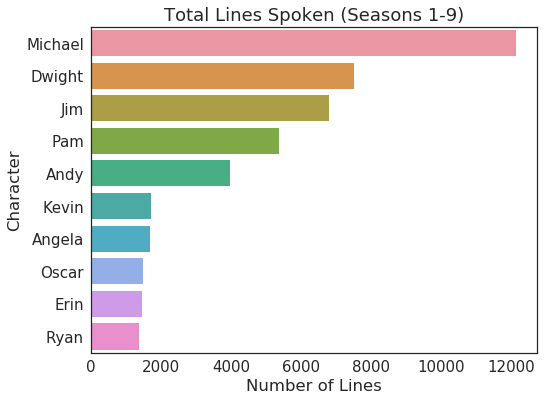

In [78]:
sns.set(font_scale=1.5)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8,6))

total_line_plot = sns.barplot('line','character', data=total_lines[total_lines['character'].isin(top_ten)], ax=ax)
ax.set(xlabel="Number of Lines", ylabel="Character")
ax.set_title("Total Lines Spoken (Seasons 1-9)")
#total_line_plot.get_figure().savefig("imgs/total-char-lines.png")

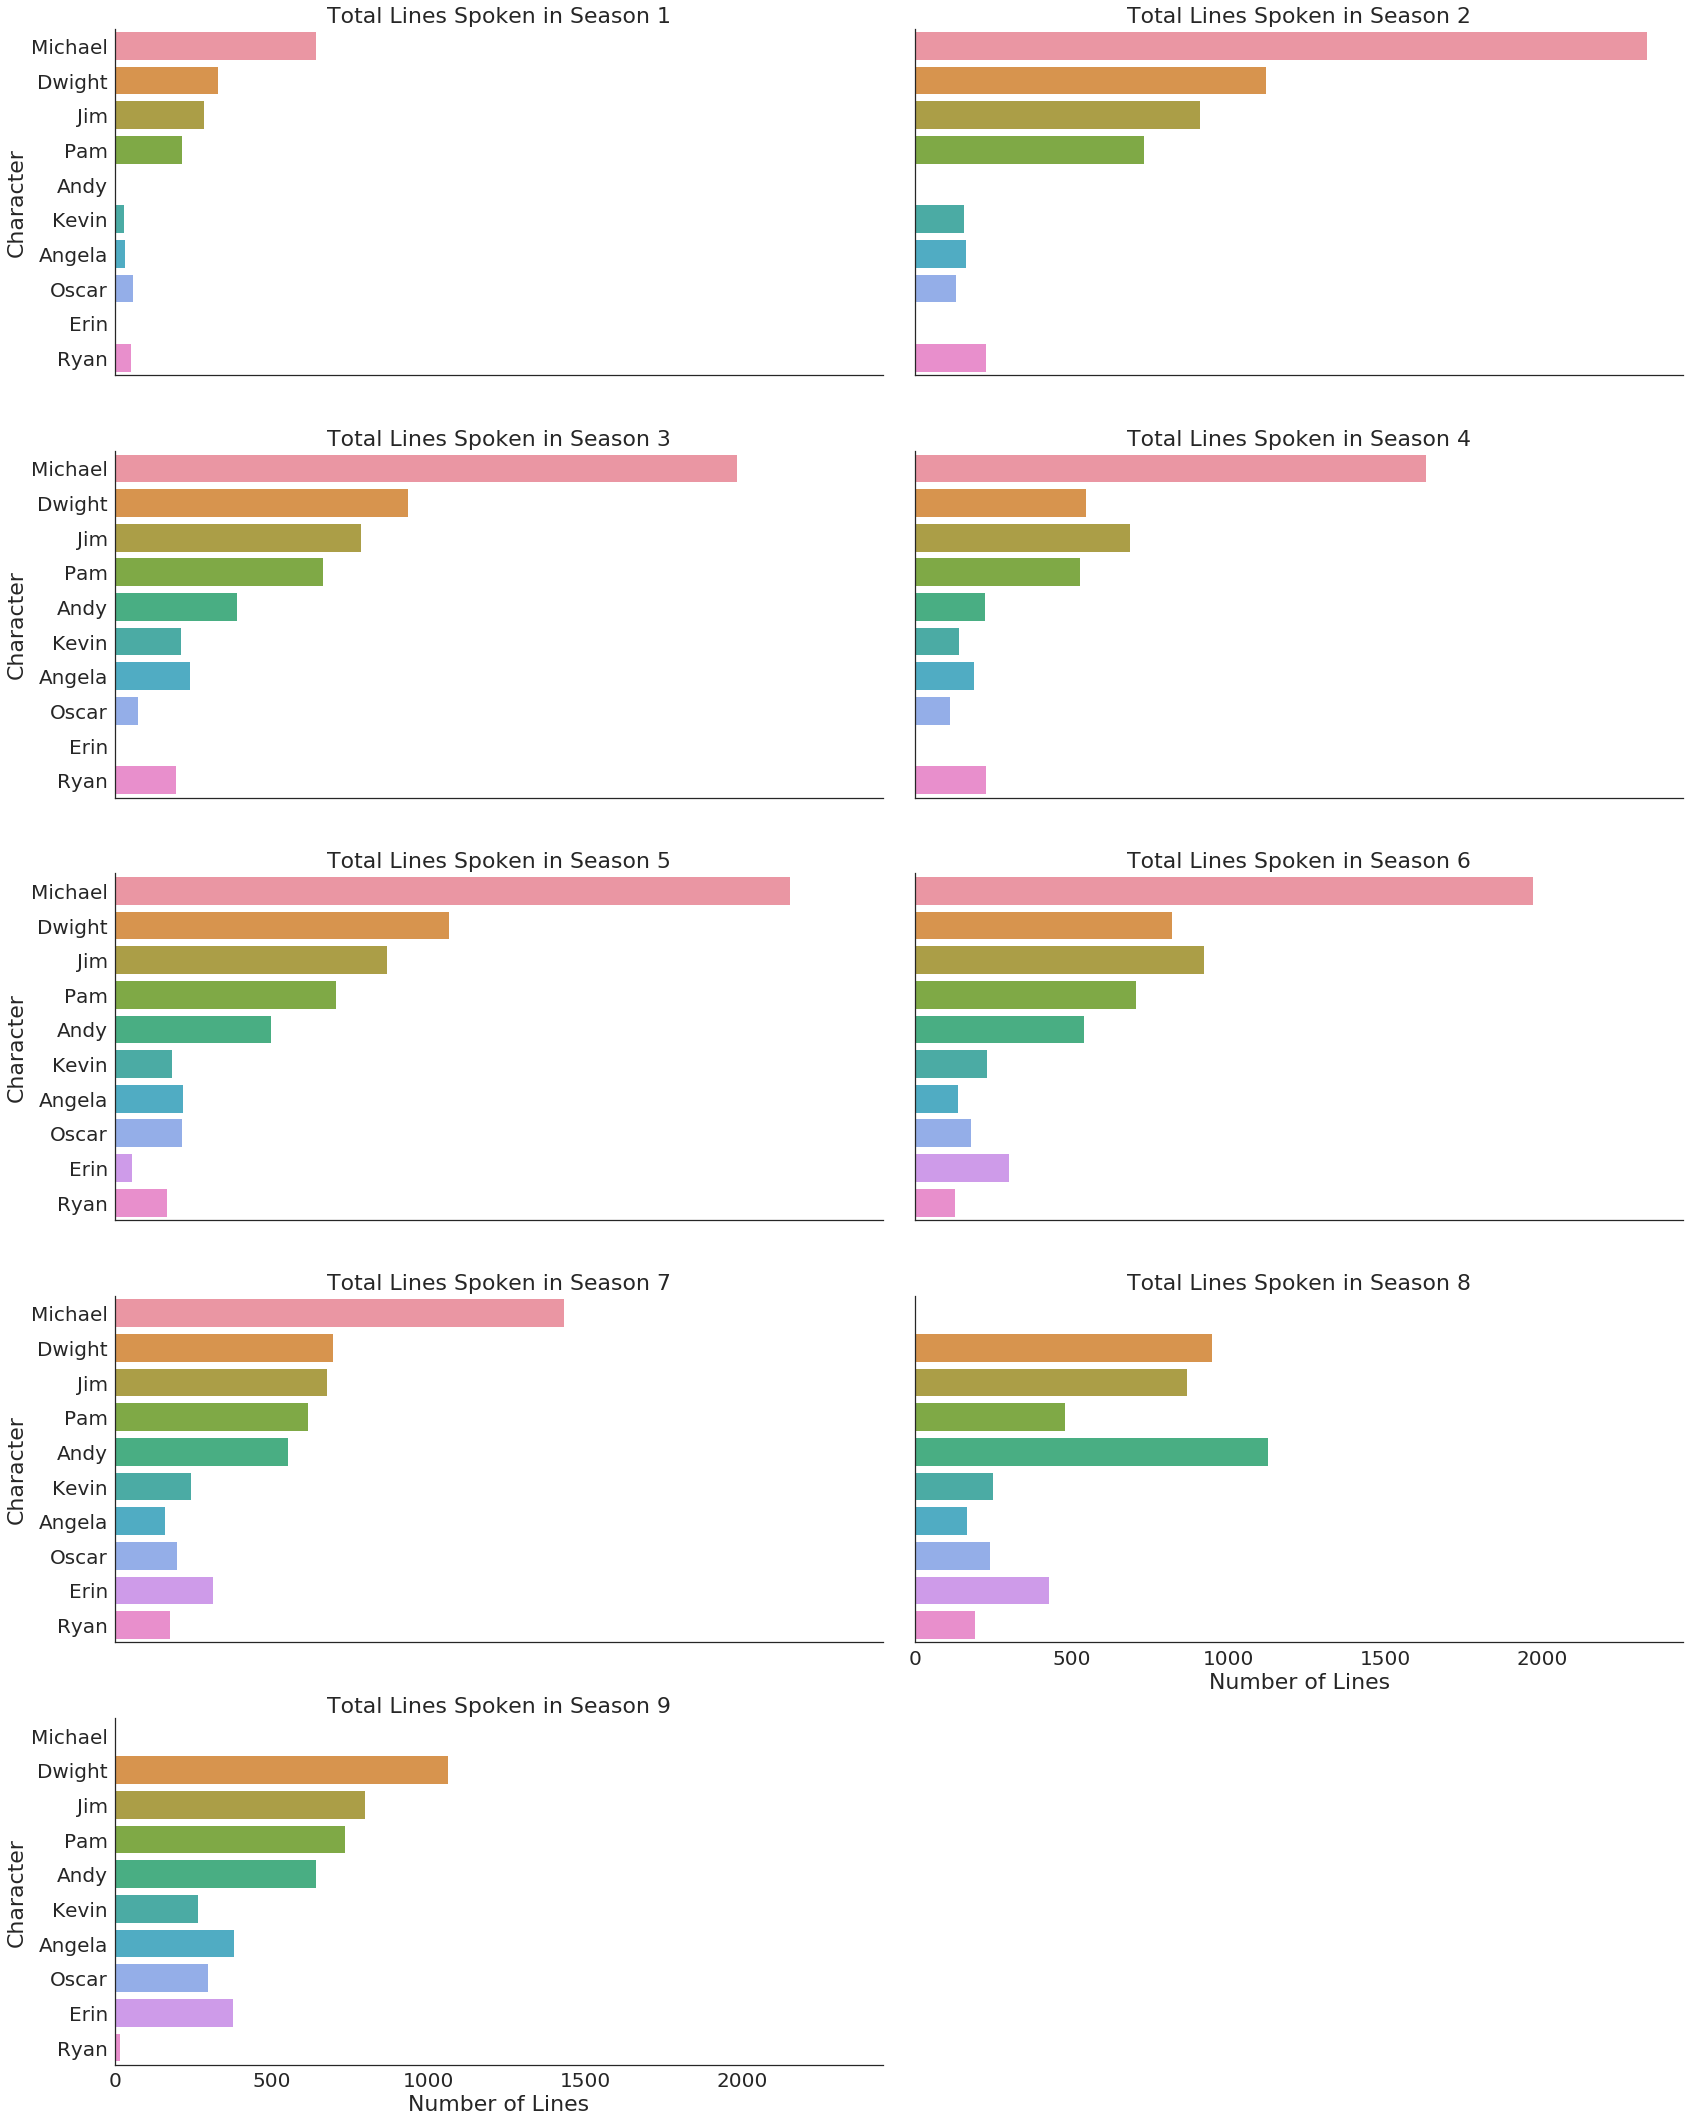

In [79]:
#plt.style.use('default')
sns.set(font_scale=2)
sns.set_style("white")
line_counts_top10 = line_counts[line_counts['character'].isin(top_ten)]
#sns.set(font_scale=2)
factor_plot = sns.factorplot('line', 'character',
                             col='season', col_wrap=2,
                             kind='bar', data=line_counts_top10,
                             order=top_ten, size=6, aspect=2,
                             sharex=True)
factor_plot.set_axis_labels("Number of Lines", "Character")
factor_plot.set_titles("Total Lines Spoken in Season {col_name}")
#factor_plot.savefig('imgs/total-char-line_byseason.png')

Unsurprisingly, there were many fewer lines spoken in the first season, which only had six episodes total. A lot of patterns hold for every season though. Michael consistently has the most lines, right up until his character leaves the show at the end of season seven. Pam, Jim, and Dwight make up the next three characters with the greatest number of lines in every season, with the notable exception of season eight, where Andy speaks more than anyone does.

Out focus is going to classifying lines from each character, so let's look at the overall vocabulary of the characters, building up to identifying the most common words each character says. If characters tend to have different vocabularies, then it bodes well for our ability to classify their lines accurately.

In [80]:
def get_words(s, keep_stopwords=False):
    """Return words from sentence s with with punctuation removed & words lower-case.
    Args:
        s --- string, to be tokenized
        keep_stopwords --- if False, stopwords will be removed
    Returns a list of strings.
    """
    eng_stopwords = nltk.corpus.stopwords.words('english')
    punctuation = set(string.punctuation) - set("\'")
        
    s = re.sub("[^A-Za-z0-9(),!?:\'\`]", " ", s)  # remove any special characters
    s = ''.join(list(filter(lambda x: x not in punctuation, s)))  # remove punctuation
    s = s.split()
    s = list(map(lambda x: x.lower(), s))
    if not keep_stopwords:
        s = list(filter(lambda x: x not in eng_stopwords, s))
    
    return s

In [81]:
# turn each line into a list of words, lowercase, without punctuation or stopwords
df['words'] = df['line'].apply(lambda x: get_words(x))

In [82]:
df.head()

,character,line,season,episode,words
0,Michael,All right Jim. Your quarterlies look very good...,1,1,"[right, jim, quarterlies, look, good, things, ..."
1,Jim,"Oh, I told you. I couldn't close it. So...",1,1,"[oh, told, close]"
2,Michael,So you've come to the master for guidance? Is ...,1,1,"[come, master, guidance, saying, grasshopper]"
3,Jim,"Actually, you called me in here, but yeah.",1,1,"[actually, called, yeah]"
4,Michael,"All right. Well, let me show you how it's done.",1,1,"[right, well, let, show, done]"


Let's find the most common words spoken in The Office, overall (stopwords removed).

In [83]:
word_counts = collections.Counter(itertools.chain.from_iterable(list(df.words)))

In [84]:
# total unique words spoken
len(word_counts)

20962

In [85]:
# total number of spoken words
sum(word_counts.values())

321040

In [86]:
# top ten most spoken words
word_counts.most_common(10)

[('know', 4438),
 ("i'm", 4410),
 ('oh', 4325),
 ('like', 3345),
 ('yeah', 3231),
 ('okay', 2975),
 ('right', 2690),
 ('get', 2578),
 ('well', 2516),
 ('hey', 2415)]

In [87]:
# top ten least spoken words
word_counts.most_common()[-10:]

[('uggos', 1),
 ('bestish', 1),
 ('significantly', 1),
 ('comely', 1),
 ('hooks', 1),
 ('strawberry', 1),
 ('choreographed', 1),
 ('dandelion', 1),
 ('motorhead', 1),
 ('crummy', 1)]

In fact, many words have been spoken only a single time in the entirety of The Office,

In [88]:
spoken_once = dict(filter(lambda x: x[1]==1, word_counts.items()))
len(spoken_once)

9465

What about the most common words by character?

In [89]:
def words_spoken_by(character):
    """Return a dictionary of word, word-count pairs for character.
    Args:
        character --- string, character name
    """
    
    char_df = df.loc[df['character'] == character]
    if char_df.empty:
        return "There were no words spoken by that character."
    all_words = itertools.chain.from_iterable(list(char_df.words))
    word_dict = collections.Counter(all_words)
    
    return word_dict

In [90]:
words_spoken_by('Jim').most_common(20)

[('oh', 561),
 ('know', 549),
 ("i'm", 468),
 ('right', 421),
 ('yeah', 418),
 ('okay', 387),
 ('think', 334),
 ('hey', 332),
 ('really', 332),
 ("that's", 313),
 ('dwight', 293),
 ('well', 275),
 ('uh', 263),
 ('go', 259),
 ('like', 258),
 ('good', 256),
 ('one', 240),
 ('gonna', 219),
 ('ok', 209),
 ('going', 206)]

In [91]:
words_spoken_by('Michael').most_common(20)

[('know', 1374),
 ("i'm", 1124),
 ('oh', 1058),
 ('okay', 984),
 ('like', 875),
 ('well', 826),
 ('right', 822),
 ('go', 752),
 ('going', 736),
 ('good', 730),
 ("that's", 685),
 ('get', 652),
 ('yeah', 644),
 ('think', 597),
 ('want', 574),
 ('yes', 561),
 ('hey', 561),
 ('would', 559),
 ('one', 517),
 ('ok', 489)]

In [92]:
words_spoken_by('Pam').most_common(20)

[('oh', 476),
 ('yeah', 371),
 ("i'm", 364),
 ('know', 338),
 ('like', 316),
 ('michael', 292),
 ('okay', 291),
 ('hey', 268),
 ('really', 259),
 ('think', 233),
 ('get', 225),
 ('jim', 193),
 ('um', 188),
 ('one', 182),
 ('well', 167),
 ('go', 167),
 ("that's", 163),
 ('good', 162),
 ('going', 145),
 ('want', 143)]

It's somewhat discouraging that all the characters are using the same words. It means that there won't necessarily be easy ways for us to classify sentences as belonging to a specific character. All hope isn't lost though, since the important thing will be the combination and frequency with which words are used together, and, eventually, the order that they say them in.

There's one final issue that we need to consider, and it's that certain lines are highly non-unique. By this I mean that there are certain lines that are said by all, or nearly all, the characters. For example,

In [93]:
# turn each line into a list of words, lowercase, without punctuation
df['words'] = df['line'].apply(lambda x: get_words(x, keep_stopwords=True))
df = df[df['character'].isin(top_ten)].reset_index(drop=True)
df['words'] = df['words'].apply(lambda x: tuple(x))

In [97]:
df_grouped = df.groupby(['words', 'character']).count().reset_index()
df_grouped[df_grouped['words']==('okay',)]

,words,character,line,season,episode
22459,"(okay,)",Andy,17,17,17
22460,"(okay,)",Angela,10,10,10
22461,"(okay,)",Dwight,32,32,32
22462,"(okay,)",Erin,12,12,12
22463,"(okay,)",Jim,81,81,81
22464,"(okay,)",Kevin,5,5,5
22465,"(okay,)",Michael,118,118,118
22466,"(okay,)",Oscar,9,9,9
22467,"(okay,)",Pam,68,68,68
22468,"(okay,)",Ryan,6,6,6


Every character has said the line 'Okay' at some point in the series. This presents a challenge for us when building a classifier. If we ask our classifier to predict on the line 'Okay', what's the right answer? It depends on which character the line was drawn from. Assuming that out training set is drawn from the dataset with similar proportions to the counts in the dataframe above, our classifier should learn that the best prediction is 'Michael', since it's most likely to be correct. But this would give us an accuracy of only,

In [98]:
118/sum(df_grouped[df_grouped['words']==('okay',)].line)

0.329608938547486

So approximately 1/3. We could have a more flexible classifier, where we can predict multiple labels for a line, and we can try to predict *all* the characters that said that particular line. This is a more challenging problem though, and one that requires a lot of data. Since there are no new episodes of The Office on the way, we're not going to get more data. Instead, we'll do some filtering. For the above case, we'll filter out all 'Okay' lines spoken by anyone that isn't Michael. We'll do the exact same for otherlines as well. We'll do this filtering when we create the training and test sets.